In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# check where BFRB data uploaded on drive
DATA_PATH = "/content/drive/MyDrive/cmi-detect-behavior-with-sensor-data/"
try:
    df_train = pd.read_csv(DATA_PATH + "train.csv")
    print("Training data loaded successfully!")
    print("Shape of the data:", df_train.shape)
    df_train.head()
except FileNotFoundError:
    print("ERROR: Could not find 'train.csv'. Please check your DATA_PATH.")
except OSError as e:
    print(f"ERROR: An OS error occurred: {e}. This might be a temporary issue with Google Drive access.")

Mounted at /content/drive
Training data loaded successfully!
Shape of the data: (574945, 341)


In [ ]:
# Time to feature engineer based on most relevant features
# relevant features were derived using random forest training model
# and then using model.feature_importances_
feature_cols = [
    'acc_x', 'acc_y', 'acc_z',
    'rot_w', 'rot_x', 'rot_y', 'rot_z',
    'thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5'
]

# Clsn up any missing values first
df_train[feature_cols] = df_train.groupby('sequence_id')[feature_cols].ffill().bfill()
df_train.fillna(0, inplace=True) # Fill any remaining NaNs with 0

print("Starting feature engineering...")

# Group by each sequence
grouped = df_train.groupby('sequence_id')

# Create an empty list to store our new features for each sequence
feature_list = []

for sequence_id, group in grouped:
    # This dictionary will hold all features for this one sequence
    features = {'sequence_id': sequence_id}

    # Calculate stats for each column
    for col in feature_cols:
        features[f'{col}_mean'] = group[col].mean()
        features[f'{col}_std'] = group[col].std()
        features[f'{col}_max'] = group[col].max()
        features[f'{col}_min'] = group[col].min()
        features[f'{col}_median'] = group[col].median()
        features[f'{col}_skew'] = group[col].skew()

    # Get the label for this sequence
    features['gesture'] = group['gesture'].iloc[0]
    feature_list.append(features)

# Convert the list of dictionaries into a new DataFrame
df_features = pd.DataFrame(feature_list)

print("Feature engineering complete!")
print("New shape of data (Sequences, Features):", df_features.shape)
df_features.head()

Starting feature engineering...
Feature engineering complete!
New shape of data (Sequences, Features): (8151, 74)


,sequence_id,acc_x_mean,acc_x_std,acc_x_max,acc_x_min,acc_x_median,acc_x_skew,acc_y_mean,acc_y_std,acc_y_max,...,thm_4_min,thm_4_median,thm_4_skew,thm_5_mean,thm_5_std,thm_5_max,thm_5_min,thm_5_median,thm_5_skew,gesture
0,SEQ_000007,6.153098,1.334155,9.015625,3.613281,6.488281,-0.545319,3.915570,3.048287,6.519531,...,28.592863,29.124386,0.538690,27.957446,0.877846,29.428299,26.047148,28.181814,-0.738914,Cheek - pinch skin
1,SEQ_000008,3.400506,1.087142,5.906250,1.734375,3.437500,0.146452,5.311179,3.268073,8.667969,...,28.755495,30.809861,-0.632604,25.824221,1.165940,28.054575,24.181562,25.127313,0.522887,Forehead - pull hairline
2,SEQ_000013,-7.058962,1.295184,-3.347656,-9.250000,-7.144531,0.518519,2.346182,2.564639,4.683594,...,24.419798,24.666821,1.551367,24.733322,0.475044,26.051331,24.167980,24.594648,1.650349,Cheek - pinch skin
3,SEQ_000016,5.524654,1.074108,9.378906,3.437500,5.390625,0.747648,-4.408491,0.598318,-2.960938,...,27.227589,34.618870,-0.846693,30.860562,3.310154,35.801083,26.312038,30.702021,-0.048033,Write name on leg
4,SEQ_000018,5.363715,1.627637,6.832031,1.964844,6.101562,-1.397824,4.109737,3.525304,6.718750,...,26.827133,27.972450,-0.974528,31.014364,1.394629,32.180752,28.282324,31.771284,-1.213819,Forehead - pull hairline


In [ ]:
X = df_features.drop(columns=['sequence_id', 'gesture'])
y_raw = df_features['gesture']

# Encode the string labels into numbers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print("Data is ready for modeling.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Data is ready for modeling.
X_train shape: (6113, 72)
X_test shape: (2038, 72)


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

for name, model in models.items():
    print(f"--- Training {name} ---")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    print("-" * 50 + "\n")

--- Training Logistic Regression ---
Accuracy: 0.4504
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.56      0.65      0.60       160
                        Cheek - pinch skin       0.29      0.28      0.28       160
                     Drink from bottle/cup       0.67      0.78      0.72        40
                       Eyebrow - pull hair       0.24      0.14      0.18       160
                       Eyelash - pull hair       0.30      0.29      0.30       160
Feel around in tray and pull out an object       0.79      0.93      0.85        40
                  Forehead - pull hairline       0.42      0.42      0.42       160
                        Forehead - scratch       0.49      0.60      0.54       160
                            Glasses on/off       0.56      0.78      0.65        40
                         Neck - pinch skin       0.26      0.21      0.23       160
                     

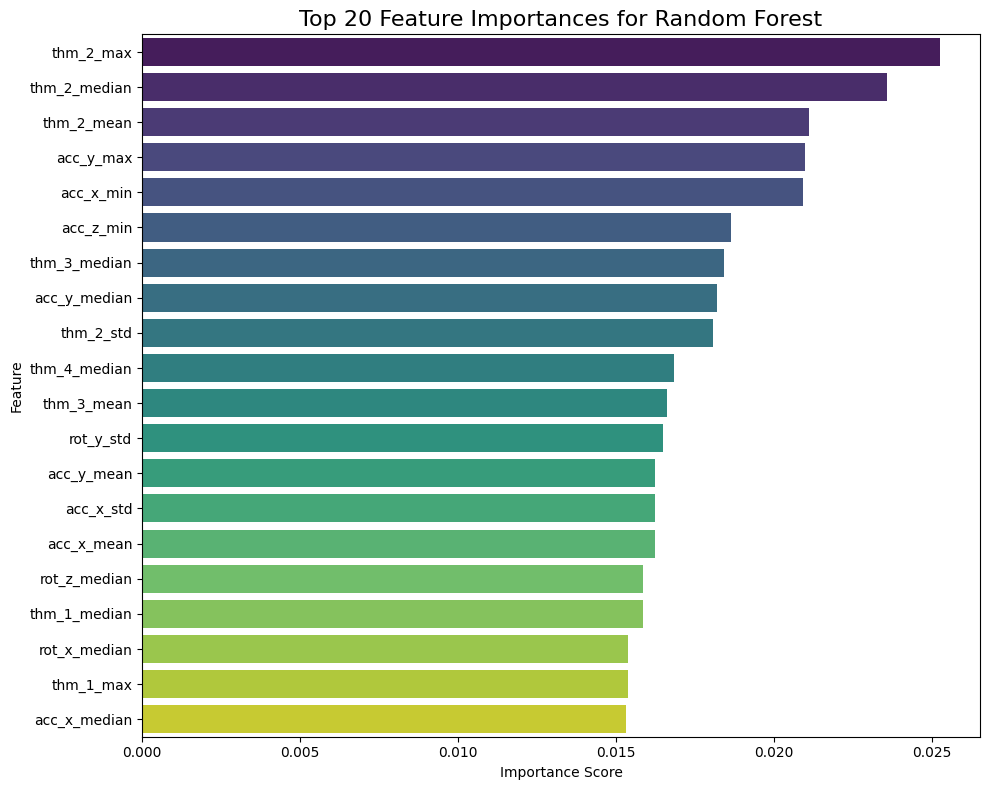

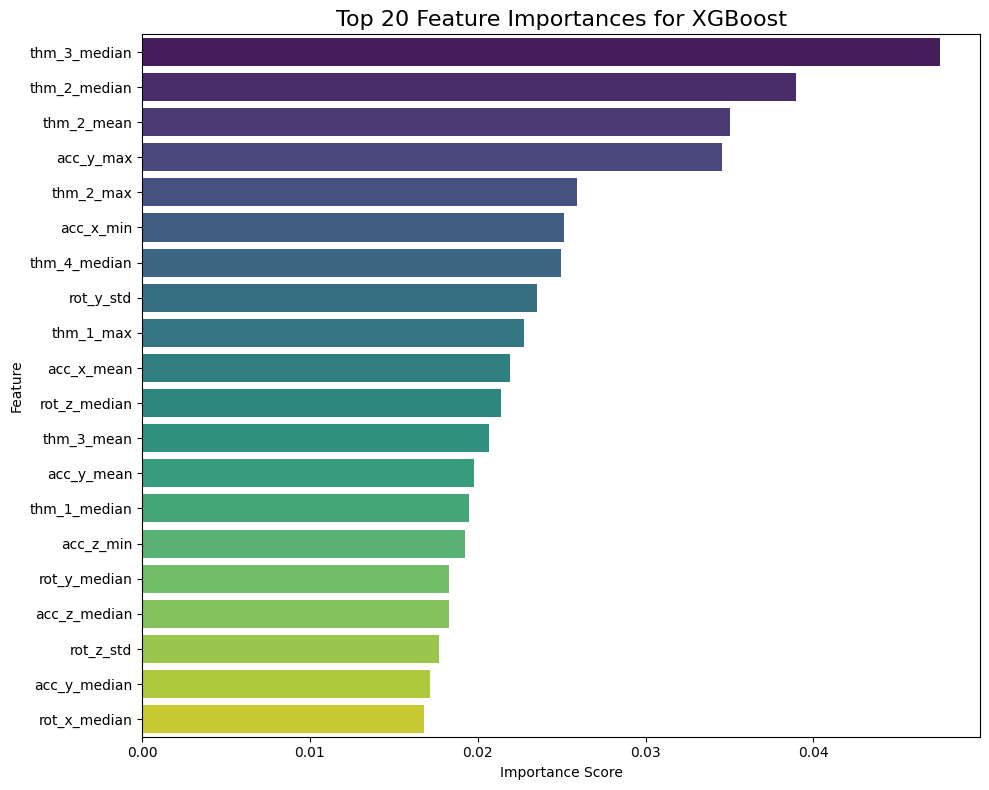

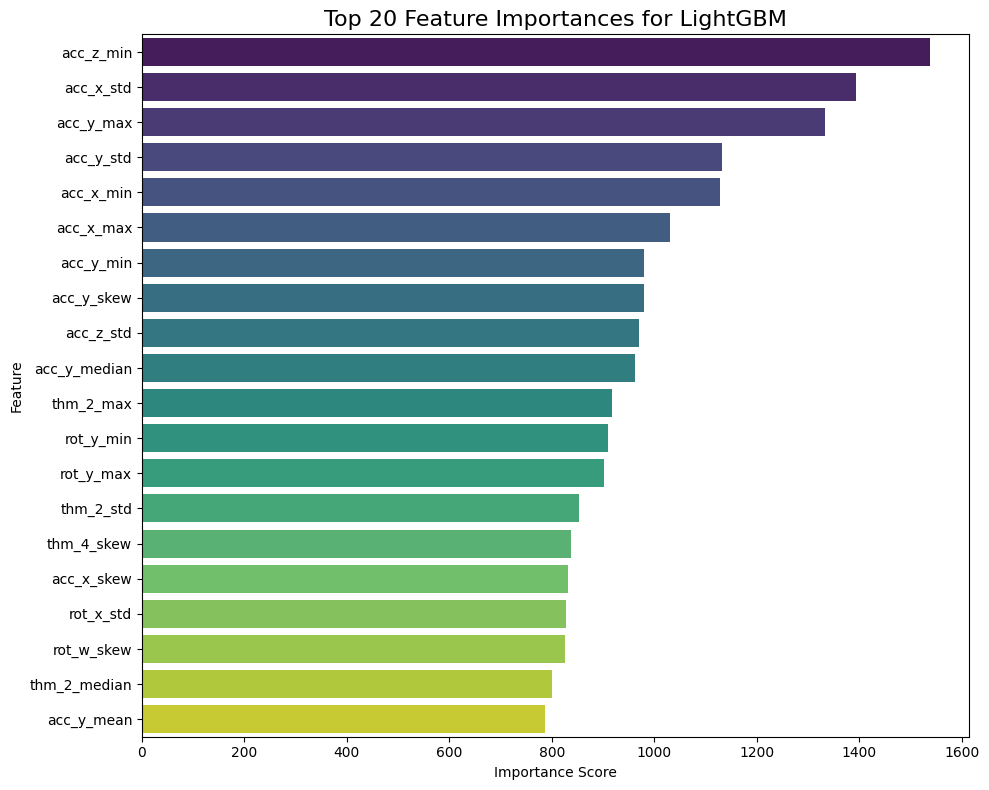

In [ ]:
def plot_feature_importance(model, feature_names, model_name):
    """Plots the top 20 most important features for a given model."""
    # Create a dataframe of features and their importance scores
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=importances, palette='viridis')
    plt.title(f'Top 20 Feature Importances for {model_name}', size=16)
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

# .feature_importances_ attribute
tree_models = {
    "Random Forest": models["Random Forest"],
    "XGBoost": models["XGBoost"],
    "LightGBM": models["LightGBM"]
}

for name, model in tree_models.items():
    plot_feature_importance(model, X.columns, name)

## Trying model hyper parameter tuning for model
We can try with other ML model too just make sure to use Randomized Search cause its faster

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
# n_iter=50 means it will try 50 different random combinations
# cv=3 means it will use 3-fold cross-validation
# n_jobs=-1 means it will use all available CPU cores to speed up the search
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                                      n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
# takes a long time!!
rf_random_search.fit(X_train, y_train)

print("Best Parameters Found for Random Forest:")
print(rf_random_search.best_params_)

best_rf_model = rf_random_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
print("\nAccuracy of the tuned Random Forest:")
print(accuracy_score(y_test, y_pred))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters Found for Random Forest:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'bootstrap': False}

Accuracy of the tuned Random Forest:
0.5137389597644749
